In [ ]:
!pip install yfinance
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib.backends.backend_pdf import PdfPages
from google.colab import files
from PIL import Image

In [ ]:
class Forecast:
    def __init__(self, stock_symbol):
        self.stock_symbol = stock_symbol
        self.data = None  # To store the downloaded stock data
        self.ds = None
        self.ds_test = None
        self.ds_train = None
        self.X_Train = None
        self.X_Test = None
        self.Y_Train = None
        self.Y_Test = None
        self.normalizer = None
        self.ds_scaled = None

    def stock_log(self):
        self.data = yf.download(tickers=self.stock_symbol, period='10y', interval='1d')

    def Open_Stock(self):
        if self.data is None:
            print("Stock data not available. Call stock_log() first.")
            return

        opn = self.data['Open']
        self.ds = opn.values
        opn.plot()
        plt.title(f"Open Stock Prices for {self.stock_symbol}")
        plt.xlabel("Date")
        plt.ylabel("Stock Price")
        plt.show()

    def Closing_Stock(self):
        if self.data is None:
            print("Stock data not available. Call stock_log() first.")
            return

        cls = self.data['Close']
        cls.plot()
        plt.title(f"Closing Stock Prices for {self.stock_symbol}")
        plt.xlabel("Date")
        plt.ylabel("Stock Price")
        plt.show()

    def MMSclr(self):
      self.normalizer = MinMaxScaler(feature_range=(0,1))
      self.ds_scaled = self.normalizer.fit_transform(np.array(self.ds).reshape(-1,1))
      train_size = int(len(self.ds_scaled)*0.85)
      test_size = len(self.ds_scaled) - train_size
      self.ds_train, self.ds_test = self.ds_scaled[0:train_size,:], self.ds_scaled[train_size:len(self.ds_scaled),:1]

    def create_ds(self,dataset,step):
      Xtrain, Ytrain = [], []
      for i in range(len(dataset)-step-1):
          a = dataset[i:(i+step), 0]
          Xtrain.append(a)
          Ytrain.append(dataset[i + step, 0])
      return np.array(Xtrain), np.array(Ytrain)

    def Model(self):
      self.stock_log()
      self.Open_Stock()
      self.Closing_Stock()
      self.MMSclr()
      time_stamp = 100
      X_train, Y_train = self.create_ds(self.ds_train,time_stamp)
      X_test, Y_test = self.create_ds(self.ds_test,time_stamp)
      X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
      X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
      model = Sequential()
      model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
      model.add(LSTM(units=50,return_sequences=True))
      model.add(LSTM(units=50))
      model.add(Dense(units=1,activation='linear'))
      model.summary()
      model.compile(loss='mean_squared_error',optimizer='adam')
      model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=5,batch_size=64)
      loss = model.history.history['loss']
      train_predict = model.predict(X_train)
      test_predict = model.predict(X_test)
      train_predict = self.normalizer.inverse_transform(train_predict)
      test_predict = self.normalizer.inverse_transform(test_predict)
      test = np.vstack((train_predict,test_predict))
      fut_inp = self.ds_test[197:]
      fut_inp = fut_inp.reshape(1,-1)
      tmp_inp = list(fut_inp)
      tmp_inp = tmp_inp[0].tolist()
      lst_output=[]
      n_steps=172
      i=0
      while(i<30):

          if(len(tmp_inp)>100):
              fut_inp = np.array(tmp_inp[1:])
              fut_inp=fut_inp.reshape(1,-1)
              fut_inp = fut_inp.reshape((1, n_steps, 1))
              yhat = model.predict(fut_inp, verbose=0)
              tmp_inp.extend(yhat[0].tolist())
              tmp_inp = tmp_inp[1:]
              lst_output.extend(yhat.tolist())
              i=i+1
          else:
              fut_inp = fut_inp.reshape((1, n_steps,1))
              yhat = model.predict(fut_inp, verbose=0)
              tmp_inp.extend(yhat[0].tolist())
              lst_output.extend(yhat.tolist())
              i=i+1


      print(lst_output)
      plot_new=np.arange(1,101)
      plot_pred=np.arange(101,131)
      ds_new = self.ds_scaled.tolist()
      ds_new.extend(lst_output)
      final_graph = self.normalizer.inverse_transform(ds_new).tolist()
      plt.plot(final_graph,)
      plt.ylabel("Price")
      plt.xlabel("Time in Days")
      plt.title("{0} prediction of next month open".format(self.stock_symbol))
      plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
      plt.legend()
      plt.savefig(self.stock_symbol + '.jpg')
      figure_path = ('/content/' + self.stock_symbol + '.jpg')  # Replace with your actual file path

      img = Image.open(figure_path)
      pdf_filename = (self.stock_symbol + '.pdf')

      img.save(pdf_filename, 'PDF')
      files.download(pdf_filename)

[*********************100%%**********************]  1 of 1 completed


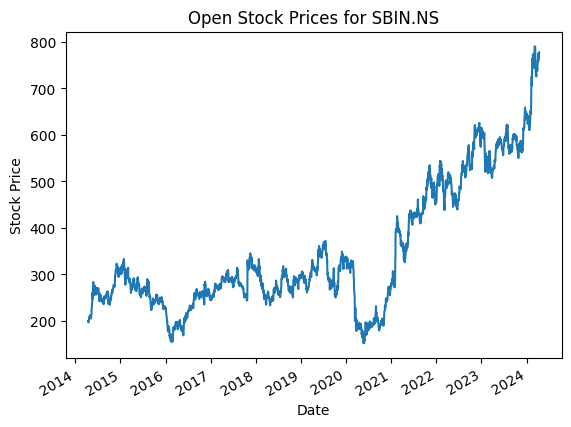

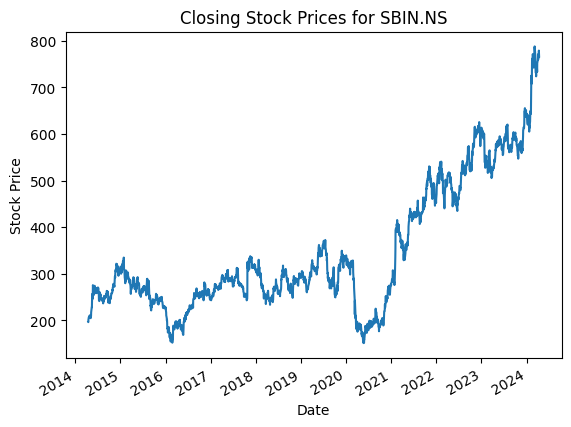

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
32/32 [==============================] - 26s 351ms/step - loss: 0.0076 - val_loss: 0.0046
Epoch 2/5
32/32 [==============================] -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

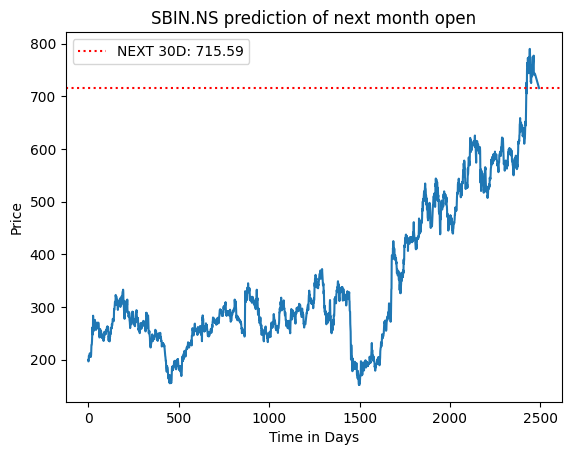

In [ ]:
SBI = Forecast("SBIN.NS")
SBI.Model()